In [1]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
sys.path.insert(1, oj(sys.path[0], '..', 'vision_fit'))  # insert parent path
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import math
# plt.style.use('dark_background')
from mog_fit import data
from collections import OrderedDict
from sklearn import preprocessing

import torch
from torch.autograd import Variable
from mog_analyze import viz
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

from vision_fit import data

import viz_weights
%matplotlib inline
%load_ext autoreload
%autoreload 2

import style
cb = '#33ccff'

In [2]:
style.set_style()

# load results from a directory

In [3]:
# depending on how much is saved, this may take a while
out_dir = '/scratch/users/vision/yu_dl/raaz.rsk/track_acts/lay1_big_lrs'
fnames = sorted([fname for fname in os.listdir(out_dir) ])
#                  if not 'mnist' in fname and 
#                  'numlays=4' in fname and 
#                  'batchsize=100' in fname and not 'batchsize=1000' in fname])
#                   and 
#                  'numlays=4' in fname]) # and 
#                  'batchsize=100' in fname and 
#                  not 'batchsize=1000' in fname])
# weights_list = [pd.Series(pkl.load(open(oj(out_dir, fname), "rb"))) for fname in tqdm(fnames) 
#                 if fname.startswith('weights')]
# results_weights = pd.concat(weights_list, axis=1).T.infer_objects()

results_list = [pd.Series(pkl.load(open(oj(out_dir, fname), "rb"))) for fname in tqdm(fnames) 
                if not fname.startswith('weights') and not fname.startswith('idx')]
results = pd.concat(results_list, axis=1).T.infer_objects()

save_dir = 'results_weights'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
# print('loaded', results_weights.shape[0], 'runs')

100%|██████████| 51/51 [00:00<00:00, 158.06it/s]


# add cols

In [4]:
# things that were renamed
# singular_val_dicts_pca -> singular_val_dicts
# act_singular_val_dicts_train_pca -> act_singular_val_dicts_train
# fc2 -> fc.1

def stable_rank(svals): return np.sum(svals ** 2)/np.max(svals**2)
def trykey(d, key):
    try: return d.key
    except: return np.nan

# this fixes an err where previous model accidentally saved fc.1 as fc2 for 2-lay models
def try_key_fc2(d): 
    try: return d['fc2']
    except: return d['fc.1']


ts = sorted(results.iloc[0]['mean_max_corrs'].keys())
t_max_w = int(max(ts))
corr0, corr0_adj, corr1, corr1_adj = [], [], [], []
fc0_fro, fc1_fro, fc0_stab_rank, fc1_stab_rank = [], [], [], []
act0_stab_rank, act1_stab_rank = [], []
for _, row in results.iterrows():
    mem_stat_dict0 = [row['mean_max_corrs'][t]['fc.0.weight'] for t in ts]
    corr0.append([np.mean(d['max_corrs']) for d in mem_stat_dict0])
#     corr0_adj.append([np.multiply(d['W_norms'], d['max_corrs'])/np.sum(d['W_norms']) for d in mem_stat_dict0])
#     print(corr0)
    # add smth about mean class corr?
    mem_stat_dict1 = [row['mean_max_corrs'][t]['fc.1.weight'] for t in ts]
    corr1.append([np.mean(d['max_corrs']) for d in mem_stat_dict1])
#     corr1_adj.append([np.multiply(d['W_norms'], d['max_corrs'])/np.sum(d['W_norms']) for d in mem_stat_dict1])

    fc0_fro.append([row['weight_norms'][t]['fc.0.weight_fro'] for t in ts])
    fc1_fro.append([row['weight_norms'][t]['fc.1.weight_fro'] for t in ts])    
    
    fc0_stab_rank.append(np.array(np.apply_along_axis(stable_rank, axis=1, arr=[row['singular_val_dicts'][int(t)]['fc.0.weight'] for t in ts])))
    fc1_stab_rank.append(np.apply_along_axis(stable_rank, axis=1, arr=[row['singular_val_dicts'][int(t)]['fc.1.weight'] for t in ts]))
    
    act0_stab_rank.append(np.apply_along_axis(stable_rank, axis=1, arr=[row['act_singular_val_dicts_train'][int(t)]['fc.0'] for t in ts]))
    act1_stab_rank.append(np.apply_along_axis(stable_rank, axis=1, arr=[try_key_fc2(row['act_singular_val_dicts_train'][int(t)]) for t in ts]))
    
    
# array summaries    
results['fc0_fro'] = fc0_fro
results['fc1_fro'] = fc1_fro
results['fc0_stab_rank'] = fc0_stab_rank
results['fc1_stab_rank'] = fc1_stab_rank
results['act0_stab_rank'] = act0_stab_rank
results['act1_stab_rank'] = act1_stab_rank
results['corr0'] = corr0
results['corr1'] = corr1
# results['corr0_adj'] = corr0
# results['corr1_adj'] = corr1
    

# scalar summaries
results['max_train_acc'] = np.array([max(results.accs_train[i]) for i in range(len(results)) ]) 
results['max_test_acc'] = np.array([max(results.accs_test[i]) for i in range(len(results)) ])
results['corr0_final'] = np.array([results.corr0[i][-1] for i in range(len(results))])
results['corr1_final'] = np.array([results.corr1[i][-1] for i in range(len(results))])
# results['corr0_adj_final'] = np.array([results.corr0_adj[i][-1] for i in range(len(results))])
# results['corr1_adj_final'] = np.array([results.corr1_adj[i][-1] for i in range(len(results))])
results['fc0_fro_final'] = np.array([results.fc0_fro[i][-1] for i in range(len(results))]) #[results.iloc[row_num]['weight_norms'][t_max_w]['fc.0.weight_fro'] for row_num in results.index]
results['fc1_fro_final'] = [results.iloc[row_num]['weight_norms'][t_max_w]['fc.1.weight_fro'] for row_num in results.index]
results['fc0_stab_rank_final'] = [stable_rank(results.iloc[row_num]['singular_val_dicts'][t_max_w]['fc.0.weight'])
                                  for row_num in results.index]
results['fc1_stab_rank_final'] = [stable_rank(results.iloc[row_num]['singular_val_dicts'][t_max_w]['fc.1.weight'])
                                  for row_num in results.index]
results['act0_stab_rank_final'] = [stable_rank(results.iloc[row_num]['act_singular_val_dicts_train'][t_max_w]['fc.0'])
                                  for row_num in results.index]
results['act1_stab_rank_final'] = [stable_rank(try_key_fc2(results.iloc[row_num]['act_singular_val_dicts_train'][t_max_w]))
                                  for row_num in results.index]

# plot max corrs
*note some things disappear in below plot as a result of nans*

(0, 1)

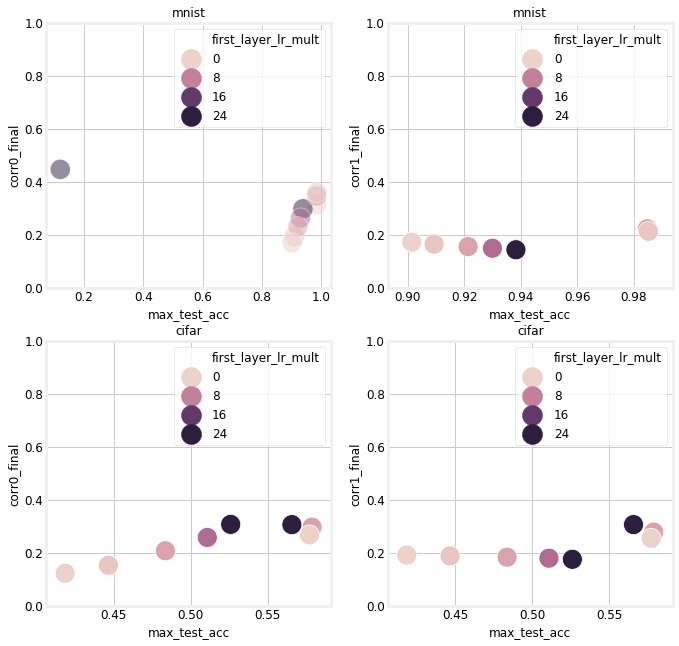

In [19]:
r = results[results.seed == 0]
# r = results[results.num_layers == 4]
# print(r[['lr', 'first_layer_lr_mult', 'corr0_final']])
hue = 'first_layer_lr_mult'

plt.figure(figsize=(10, 10))
R, C = 2, 2
rm = r[r.dset == 'mnist']
# rm = rm[rm.max_test_acc > 0.9]
plt.subplot(R, C, 1)
plt.title('mnist')

sns.scatterplot(rm.max_test_acc, rm.corr0_final, hue=rm[hue], alpha=0.5)
plt.ylim(0, 1)

plt.subplot(R, C, 2)
plt.title('mnist')
sns.scatterplot(rm.max_test_acc, rm.corr1_final, hue=rm[hue])
plt.ylim(0, 1)


rm = r[r.dset == 'cifar10']
# rm = rm[rm.max_test_acc > 0.4]
plt.subplot(R, C, 3)
plt.title('cifar')
sns.scatterplot(rm.max_test_acc, rm.corr0_final, hue=rm[hue])
plt.ylim(0, 1)

plt.subplot(R, C, 4)
plt.title('cifar')
sns.scatterplot(rm.max_test_acc, rm.corr1_final, hue=rm[hue])
plt.ylim(0, 1)

# track things over time

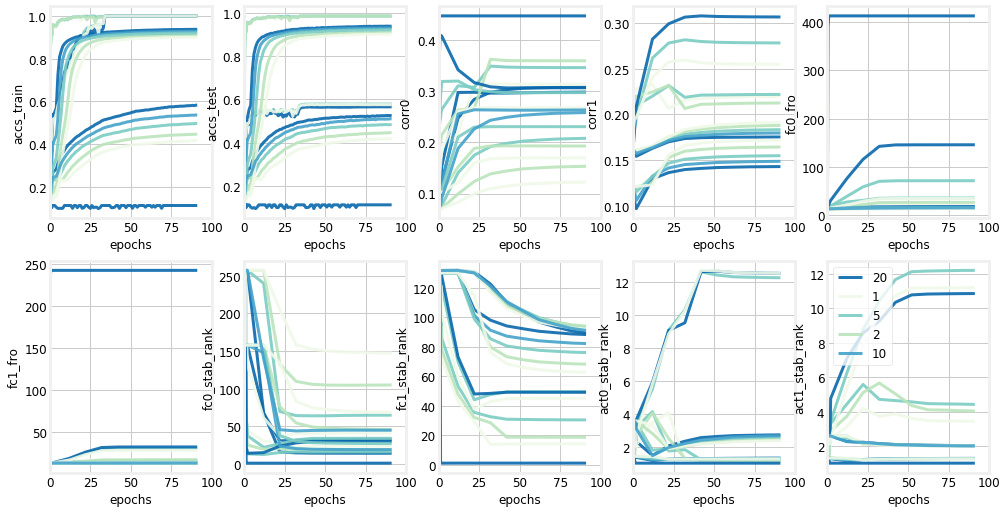

In [22]:
rm = results
# rm = results[(results.dset == 'mnist') * (results.max_test_acc >= 0.9) * (results.seed==0)] # good mnist
# rm = results[(results.dset == 'mnist') * (results.max_test_acc < 0.9) * (results.seed==0)] # bad mnist
# rm = results[(results.dset == 'cifar10') * (results.max_test_acc >= 0.4) * (results.seed==0)] # good cifar10
# rm = results[(results.dset == 'cifar10') * (results.max_test_acc < 0.4) * (results.seed==0)] # good cifar10
R, C = 2, 5
plt.figure(figsize=(15, 8))
xlim = 100
cs_5 = {1: '#f0f9e8', 2: '#bae4bc', 5: '#7bccc4', 10: '#43a2ca', 20: '#0868ac'}
vals = ['accs_train', 'accs_test', 'corr0', 'corr1', 'fc0_fro', 'fc1_fro', 'fc0_stab_rank', 'fc1_stab_rank', 'act0_stab_rank', 'act1_stab_rank']

# well-behaved
for j, (_, row) in enumerate(rm.iterrows()):

    for i, val in enumerate(vals):
        plt.subplot(R, C, i+1)
        try:
            plt.plot(ts, row[val], color=cs_5[row.first_layer_lr_mult], label=row.first_layer_lr_mult, alpha=0.9)
        except:
            plt.plot(row.its[:row[val].size], row[val], color=cs_5[row.first_layer_lr_mult], label=row.first_layer_lr_mult, alpha=0.9)
        plt.xlabel('epochs')
        plt.ylabel(val)
        plt.xlim((0, xlim))
    
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

## plot these things against one another
**overmemorization in the beginning can still maintain high train acc but suffers on test acc**

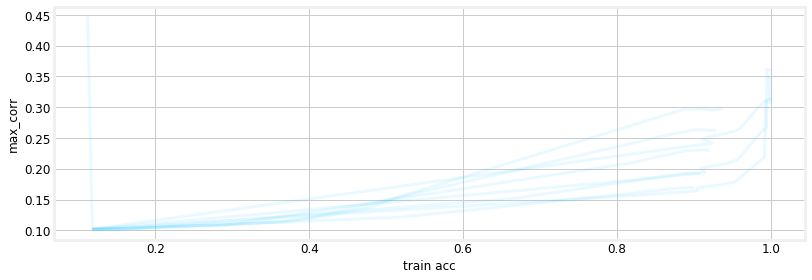

In [23]:
rm = results[(results.seed == 0) * (results.dset == 'mnist')]
# rm = results[(results.dset == 'mnist') * (results.max_test_acc >= 0.8)]
plt.figure(figsize=(12, 4))
R, C = 1, 1
for _, row in rm.iterrows():

    plt.subplot(R, C, 1)
    idxs = [True if v in ts else False for v in row.its[:row.accs_train.size]]
    accs_train = row.accs_train[idxs]
    plt.plot(accs_train, row.corr0, color='red' if row.optimizer=='adam' else cb, alpha=0.1)
#     plt.scatter(accs_train, row.corr0, c=accs_train) #color='red' if row.optimizer=='adam' else cb, alpha=0.1)    
#     plt.plot([accs_train[0], accs_train[1], accs_train[-1]], [row.corr0[0], row.corr0[1], row.corr0[-1]]) #, color='red' if row.optimizer=='adam' else cb, alpha=0.1)    
#     plt.plot([accs_train[3], accs_train[-1]], [row.corr0[3], row.corr0[-1]], alpha=0.5) #, color='red' if row.optimizer=='adam' else cb, alpha=0.1)        
    plt.xlabel('train acc')
    plt.ylabel('max_corr')
    
    '''
    
    plt.plot(row.its[:row.accs_train.size], row.accs_train, 
    plt.xlabel('epochs')
    plt.ylabel('max_corr')
    plt.xlim((0, 20))
    
    plt.subplot(R, C, 2)
    plt.title('max')
    
    plt.plot(ts, row.corr0, color='red' if row.optimizer=='adam' else cb, alpha=0.5)
    plt.xlabel('epochs')
    plt.ylabel('max_corr')
    plt.xlim((0, 20))
    '''
    